# **DCGAN ON FASHION MNIST DATASET**

What exactly is a DCGAN? How does it differ from a normal GAN? In what use cases does it get highlighted? These are things that we'll cover in this well documented code sample, completed with an analysis of the math and model architectures involved with the DCGAN implemented in the following paper: https://arxiv.org/abs/1511.06434v2

I hope this provides you with a more comprehensive understanding of what a DCGAN is, and helps you understand what makes it so great with an interactive sample application on the infamous Fashion-MNIST dataset, which you can explore here: https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [ ]:
!pip install tensorflow_addons
import tensorflow as tf
from tensorflow import keras
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
import tensorflow_addons as tfa

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00
Number of replicas: 1


In [ ]:
"""
Initializing constants + loading dataset
"""

bs = 64
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
num_classes = 10

(X_train, _), (X_test, _) = fashion_mnist.load_data()
dataset = np.concatenate([X_train, X_test]) 
dataset = dataset.astype('float32') / 255 
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(buffer_size=1024).batch(bs).prefetch(32)

print(dataset)

4422102/4422102 [==============================] - 0s 0us/step
<PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)>


Visualizing the data

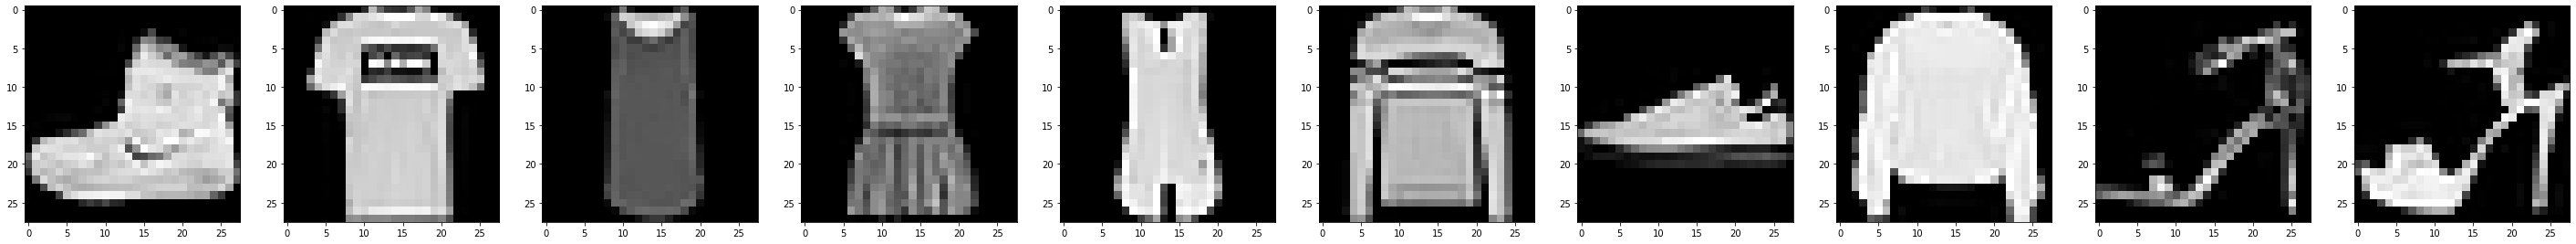

In [ ]:
f, axarr = plt.subplots(1, 10, figsize=(50,50))

for i in range(10):
  img = X_train[i]
  axarr[i % 10].imshow(img, cmap='gray')

# **BUILDING THE GAN**
First, a key part of the generator and discriminator models I intend on using is up/downsampling. While Keras has a Upsample layer within it, it's a basic, and for a lack of a better word, unintelligent approach for the upsample process. It only repeats column and row data, but we need a wiser approach to up and down sampling. This is where Conv2DTranspose comes into play. Utilizing it, we can use the following algorithms for up and down sampling.


- Upsampling Algorithm:

  - 2D Convolution Transpose with a fixed stride, specified filter and size, and randomly decided kernel initializer
  - Batch normalization with a randomly decided constraint for the gamma hyperparam
  - Output is then applied to a ReLU activation function
  - Dropout with a 50% dropout rate
<br>

- Downsampling Algorithm:

  - 2D Convolution with a fixed stride, specified filter and size, and randomly decided kernel initializer
  - Batch normalization with a randomly decided constraint for the gamma hyperparameter*
  - Output is then applied to a Leaky ReLU activation function
  - Dropout with a 50% dropout rate
<br>
<br>

  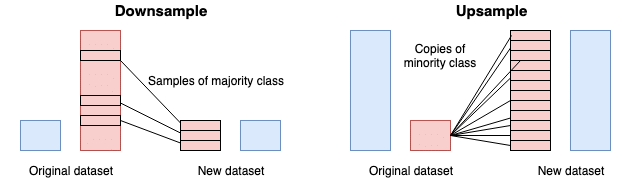

<br>
<br>

SELF NOTE:
What exactly is the gamma hyperparameter in normalization? 
- Context: The zero unit variance distribution formula: `y = Gamma*X_norm + Beta = X_norm`
- Inherently, by setting the initializing gamma as 0, one would be eliminating the x term in the equation. The gamma initializer allows you to establish a starting point for the gamma coef, so that it transforms the input to zero unit variance distributions, but during training the model, it can adjust those parameters if it finds that it works better for the current layer.

In [ ]:
def upsample(filters, size, apply_dropout=False):
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    seq = keras.Sequential()

    upsample_layers = [
        keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer = init, use_bias = False),
        keras.layers.BatchNormalization(gamma_initializer = gamma_init),
        keras.layers.ReLU()
    ]
    
    if (apply_dropout):
      keras.layers.Dropout(0.5)

    for layer in upsample_layers:
        seq.add(layer)

    return seq


def downsample(filters, size, apply_norm=True):
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    seq = keras.Sequential()
    
    seq.add(keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer = init, use_bias = False))

    if (apply_norm):
      seq.add(keras.layers.BatchNormalization(gamma_initializer = gamma_init))
    
    seq.add(keras.layers.LeakyReLU(alpha = 0.2))
    seq.add(keras.layers.Dropout(0.5))
      
    return seq

## BUILDING THE GENERATOR

What exactly is the purpose of the generator?
- To oversimplify it, the generator inherently has a responsibility to try and outsmart the discriminator into thinking that the images that the generator has produced are real images - to do this, it is in a constant back and forth, which we will establish later on during the portion in which we construct the holistic GAN and discuss the training cycle.

Generator Architecture:
- It begins with a Dense or fully connected layer that converts the data into a tensor, which represents a point in the latent space. After applying a ReLU activation function and performing batch normalization on the data, it then uses it to make multiple 7x7 feature maps, which is up sampled to multiple 28x28 feature maps. It is then convolved to just one 28x28 output feature map.
- The upsampling algorithm described earlier is detailed above.
<br>
<br>
- The following is the model for the generator that the paper describes. 

   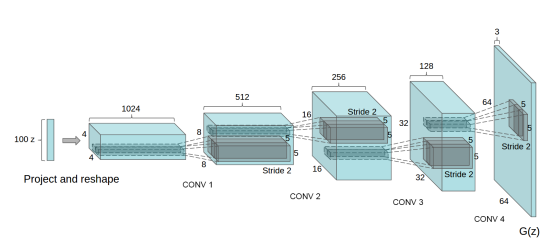

- According to Papers With Code, the following changes to the default GAN structure must be incorporated in this implementation.
  - Replacing any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
  - Using batchnorm in both the generator and the discriminator.
  - Removing fully connected hidden layers for deeper architectures.
  - Using ReLU activation in generator for all layers except for the output, which uses tanh.
  - Using LeakyReLU activation in the discriminator for all layer.

In [ ]:
def build_generator():
  layers = [
      keras.layers.Dense(7 * 7 * 128, input_dim = 128),                #(bs, 6272)
      keras.layers.ReLU(),                                             #(bs, 6272)
      keras.layers.Reshape((7,7,128)),                                 #(bs, 7, 7, 128)
      upsample(128, 4, apply_dropout=True),                            #(bs, 28, 28, 128)
      upsample(128, 4, apply_dropout=True),                            #(bs, 28, 28, 128)
      keras.layers.Conv2D(1, 7, padding='same', activation='tanh')     #(bs, 28, 28, 1)
  ]

  return keras.Sequential(layers)

In [ ]:
with strategy.scope():
  gen = build_generator()
  gen.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 re_lu (ReLU)                (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 sequential (Sequential)     (None, 14, 14, 128)       262656    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 128)       262656    
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 1)         6273      
                                                                 
Total params: 1,340,673
Trainable params: 1,340,161
No

## BUILDING THE DISCRIMINATOR
What exactly is the purpose of the discriminator?
- The discriminator inherently attempts to isolate generated images from real images. It engages in a back and forth with the generator in an attempt to force the generator to produce more and more realistic intepretations of the subject till the target is replicable in the eyes of the discriminator. This back and forth is forwarded via the training cycle.
<br>


Discriminator Architecture:

- It begins with a series of downsamplings which reduce the size of the image from 28x28 to 2x2, continuing to decrease the size of the feature map while increasing the number of feature maps. It then globally max pools, reducing dimensionality, and then follows that with a Dense layer which consolidates it into 1 output.

The downsampling algorithm described earlier is detailed above.

- This is the model the paper describes for the discriminator:
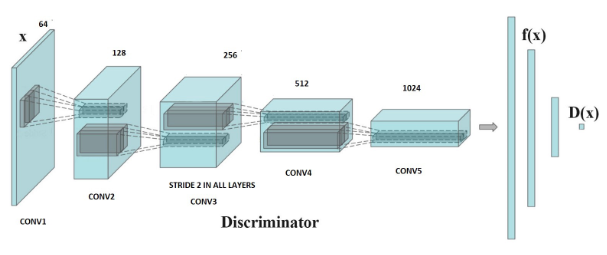

- According to Papers With Code, the following changes to the default GAN structure must be incorporated in this implementation.
  - Replacing any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
  - Using batchnorm in both the generator and the discriminator.
  - Removing fully connected hidden layers for deeper architectures.
  - Using ReLU activation in generator for all layers except for the output, which uses tanh.
  - Using LeakyReLU activation in the discriminator for all layer.

In [ ]:
def build_discriminator():
  layers = [
      keras.layers.Input(shape=[28,28,1]),
      downsample(32, 3, apply_norm = False),         #(bs, 14, 14, 32)
      downsample(64, 3),                             #(bs, 7, 7, 64)
      downsample(128, 3),                            #(bs, 4, 4, 128)
      downsample(256, 3),                            #(bs, 2, 2, 256)     
      keras.layers.GlobalMaxPooling2D(),             #(bs, 256)
      keras.layers.Dense(1, activation = "sigmoid")  #(bs, 1)
  ]

  return keras.Sequential(layers)

In [ ]:
with strategy.scope():
  disc = build_discriminator()
  disc.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 14, 14, 32)        288       
                                                                 
 sequential_4 (Sequential)   (None, 7, 7, 64)          18688     
                                                                 
 sequential_5 (Sequential)   (None, 4, 4, 128)         74240     
                                                                 
 sequential_6 (Sequential)   (None, 2, 2, 256)         295936    
                                                                 
 global_max_pooling2d (Globa  (None, 256)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                      

## MAKING THE DCGAN
<br>
<br>
With our DCGAN architecture now established thru the generator and discriminator, it is now time to assemble it into a holistic keras Model. 
<br>
<br>
The differences between a DCGAN and a GAN end at the implementation of the generator and discriminator, and so they operate the same at the stage of training. 

- The discriminator, as described earlier, is responsible for identifying real data from fake data, and is penalized via the loss function for each misclassification it makes. In doing so, it utilizes backprop to update the weights of the model and inherently betters it with more iterations of improvements to the discriminator.
- The generator directly feeds into the discriminator, generating fake data for the discriminator to attempt to discern from the real data. In doing so, the generator loss penalizes the generator based on whether or not the discriminator can identify the sample generated as fake. However during backprop, since the impact of a generator weight depends on the impact of the discriminator weights it feeds into, backprop starts at the output, and flows back through the discriminator to the generator. 
  - However, since we don't want the discriminator to change during the generator training, we sample random noise to produce a generator output from, have the discriminator classify it as real or fake, then calculate the disc loss and backprop thru both the disc and gen to get the gradients, which are used to update the gen weights.
<br>
<br>

The following image depicts the training cycle.
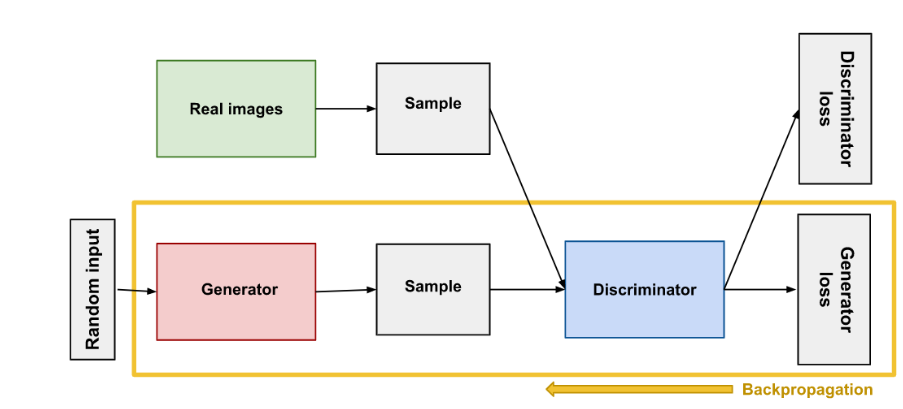

In [ ]:
class DCGAN(keras.Model):
  def __init__(self, gen, disc):
    super(DCGAN, self).__init__()
    self.gen = gen
    self.disc = disc 
  
  def compile(self, gen_opt, disc_opt, loss):
    super(DCGAN, self).compile()
    self.gen_opt = gen_opt
    self.disc_opt = disc_opt
    self.loss = loss

  def train_step(self, batch_data):
    batch_size = tf.shape(batch_data)[0]
    z = tf.random.normal(shape=(batch_size, 128))
    false_labels = tf.zeros((batch_size, 1))
    true_labels = tf.ones((batch_size, 1))

    

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
      fake_images = self.gen(z)
      fake_preds = self.disc(fake_images)
      real_preds = self.disc(batch_data)

      disc_loss = (self.loss(false_labels, fake_preds) + self.loss(true_labels, real_preds)) / 2  
      gen_loss = self.loss(fake_preds, true_labels)

      g_grads = g_tape.gradient(gen_loss, self.gen.trainable_weights)
      d_grads = d_tape.gradient(disc_loss, self.disc.trainable_weights)

      self.gen_opt.apply_gradients(zip(g_grads, self.gen.trainable_weights))
      self.disc_opt.apply_gradients(zip(d_grads, self.disc.trainable_weights))

    
    return {
        "gen_loss": gen_loss,
        "disc_loss": disc_loss,
    }
  
  def call(self, num_imgs):
    z = tf.random.normal(shape=(num_imgs, 128))
    return self.gen(z)

In [ ]:
class GANCallback(tf.keras.callbacks.Callback):
  def __init__(self, num_imgs):
    super(GANCallback, self).__init__()
    self.num_imgs = num_imgs
  
  def on_epoch_end(self, epoch, logs=None):
    if (epoch % self.num_imgs) != 0:
      return
    
    images = self.model(self.num_imgs)
    f, axarr = plt.subplots(1, self.num_imgs)
    for col in range(self.num_imgs):
      axarr[col].imshow((images[col,:,:,0]+1)*127.5, cmap='gray')
      axarr[col].axis('off')

    plt.show()

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1094/1094 [==============================] - ETA: 0s - gen_loss: 0.8290 - disc_loss: 0.6671

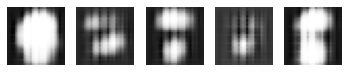

1094/1094 [==============================] - 2567s 2s/step - gen_loss: 0.8290 - disc_loss: 0.6670
Epoch 2/30
1094/1094 [==============================] - 2563s 2s/step - gen_loss: 0.8541 - disc_loss: 0.6362
Epoch 3/30
1094/1094 [==============================] - 2575s 2s/step - gen_loss: 0.8626 - disc_loss: 0.6211
Epoch 4/30
1094/1094 [==============================] - 2847s 3s/step - gen_loss: 0.8680 - disc_loss: 0.6169
Epoch 5/30
1094/1094 [==============================] - 2753s 3s/step - gen_loss: 0.8843 - disc_loss: 0.5925
Epoch 6/30
1089/1094 [============================>.] - ETA: 13s - gen_loss: 0.9011 - disc_loss: 0.5701

In [ ]:
with strategy.scope():
  lr = 2e-4
  beta_1 = 0.5

  model = DCGAN(gen=gen, disc=disc)
  model.compile(
      gen_opt = keras.optimizers.Adam(learning_rate = lr, beta_1 = beta_1),
      disc_opt = keras.optimizers.Adam(learning_rate = lr, beta_1 = beta_1),
      loss = keras.losses.BinaryCrossentropy(from_logits = True)
  )

  model.fit(dataset, epochs = 30, callbacks = [GANCallback(num_imgs = 5)])